# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [2]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.0777890682220459ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302 

## Relabeling and normilizing

In [3]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='sad')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e+02, tolerance: 6.656e-02

Text(0, 0.5, 'Coeffs')

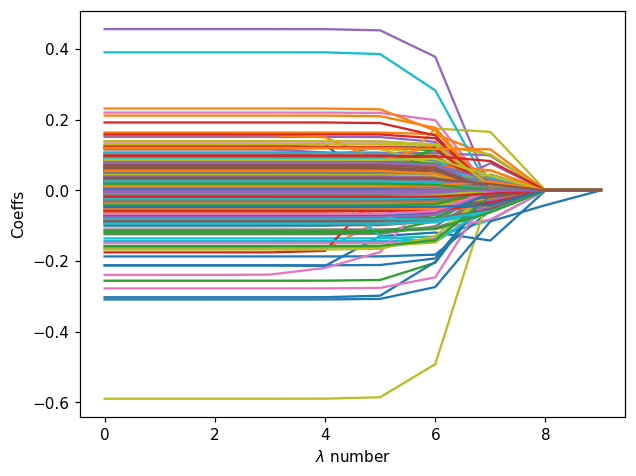

In [4]:
Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [5]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [6]:
np.save('data/Lasso_Ranking_sad_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_sad_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.6554
Iter =  3  AUC = 0.6751
Iter =  5  AUC = 0.6763
Iter =  6  AUC = 0.6903
Iter =  16  AUC = 0.7033
Iter =  18  AUC = 0.7192
Iter =  55  AUC = 0.7234
Iter =  59  AUC = 0.7238
Iter =  65  AUC = 0.7240
Iter =  66  AUC = 0.7264
Iter =  71  AUC = 0.7334
Iter =  72  AUC = 0.7402
Iter =  81  AUC = 0.7420
Iter =  83  AUC = 0.7428
auc_best = 0.74278846


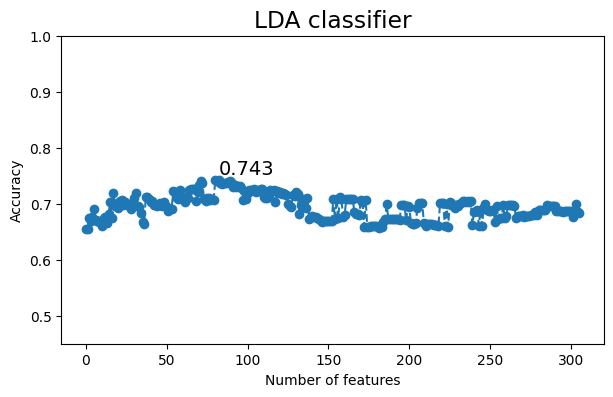

In [7]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [8]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.7427884615384616 Number of features =  82


# Backward step selection

In [9]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [10]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.737 <-> 0.743
Iter #1: 0.740 <-> 0.743
Iter #2: 0.725 <-> 0.743
Iter #3: 0.747 <-> 0.743
Iter #4: 0.742 <-> 0.743
Iter #5: 0.734 <-> 0.743
Iter #6: 0.737 <-> 0.743
Iter #7: 0.740 <-> 0.743
Iter #8: 0.743 <-> 0.743
Iter #9: 0.738 <-> 0.743
Iter #10: 0.738 <-> 0.743
Iter #11: 0.741 <-> 0.743
Iter #12: 0.744 <-> 0.743
Iter #13: 0.739 <-> 0.743
Iter #14: 0.693 <-> 0.743
Iter #15: 0.739 <-> 0.743
Iter #16: 0.735 <-> 0.743
Iter #17: 0.737 <-> 0.743
Iter #18: 0.741 <-> 0.743
Iter #19: 0.743 <-> 0.743
Iter #20: 0.741 <-> 0.743
Iter #21: 0.740 <-> 0.743
Iter #22: 0.742 <-> 0.743
Iter #23: 0.741 <-> 0.743
Iter #24: 0.740 <-> 0.743
Iter #25: 0.742 <-> 0.743
Iter #26: 0.742 <-> 0.743
Iter #27: 0.742 <-> 0.743
Iter #28: 0.732 <-> 0.743
Iter #29: 0.742 <-> 0.743
Iter #30: 0.732 <-> 0.743
Iter #31: 0.740 <-> 0.743
Iter #32: 0.735 <-> 0.743
Iter #33: 0.735 <-> 0.743
Iter #34: 0.735 <-> 0.743
Iter #35: 0.735 <-> 0.743
Iter #36: 0.735 <-> 0.743
Iter #37: 0.741 <-> 0.743
Iter #38: 0.

Iter #65: 0.698 <-> 0.748
Iter #66: 0.741 <-> 0.748
Iter #67: 0.698 <-> 0.748
Iter #68: 0.735 <-> 0.748
Iter #69: 0.741 <-> 0.748
Iter #70: 0.745 <-> 0.748
Iter #71: 0.746 <-> 0.748
Iter #72: 0.744 <-> 0.748
Iter #73: 0.743 <-> 0.748
Iter #74: 0.747 <-> 0.748
Iter #75: 0.749 <-> 0.748
Iter #76: 0.739 <-> 0.748
Iter #77: 0.748 <-> 0.748
Iter #78: 0.747 <-> 0.748
Iter #79: 0.747 <-> 0.748
Withdraw feature #39, added accracy 0
NEW ROUND
Iter #0: 0.744 <-> 0.748
Iter #1: 0.695 <-> 0.748
Iter #2: 0.695 <-> 0.748
Iter #3: 0.699 <-> 0.748
Iter #4: 0.748 <-> 0.748
Iter #5: 0.743 <-> 0.748
Iter #6: 0.745 <-> 0.748
Iter #7: 0.744 <-> 0.748
Iter #8: 0.741 <-> 0.748
Iter #9: 0.745 <-> 0.748
Iter #10: 0.704 <-> 0.748
Iter #11: 0.743 <-> 0.748
Iter #12: 0.741 <-> 0.748
Iter #13: 0.694 <-> 0.748
Iter #14: 0.746 <-> 0.748
Iter #15: 0.739 <-> 0.748
Iter #16: 0.742 <-> 0.748
Iter #17: 0.744 <-> 0.748
Iter #18: 0.718 <-> 0.748
Iter #19: 0.702 <-> 0.748
Iter #20: 0.745 <-> 0.748
Iter #21: 0.743 <-> 0.748


Iter #61: 0.746 <-> 0.748
Iter #62: 0.746 <-> 0.748
Iter #63: 0.745 <-> 0.748
Iter #64: 0.727 <-> 0.748
Iter #65: 0.744 <-> 0.748
Iter #66: 0.744 <-> 0.748
Iter #67: 0.749 <-> 0.748
Iter #68: 0.747 <-> 0.748
Iter #69: 0.747 <-> 0.748
Iter #70: 0.746 <-> 0.748
Iter #71: 0.749 <-> 0.748
Iter #72: 0.744 <-> 0.748
Iter #73: 0.747 <-> 0.748
Iter #74: 0.748 <-> 0.748
Iter #75: 0.747 <-> 0.748
Withdraw feature #3, added accracy 0
NEW ROUND
Iter #0: 0.743 <-> 0.748
Iter #1: 0.727 <-> 0.748
Iter #2: 0.741 <-> 0.748
Iter #3: 0.744 <-> 0.748
Iter #4: 0.747 <-> 0.748
Iter #5: 0.726 <-> 0.748
Iter #6: 0.728 <-> 0.748
Iter #7: 0.745 <-> 0.748
Iter #8: 0.737 <-> 0.748
Iter #9: 0.746 <-> 0.748
Iter #10: 0.742 <-> 0.748
Iter #11: 0.745 <-> 0.748
Iter #12: 0.751 <-> 0.748
Iter #13: 0.732 <-> 0.748
Iter #14: 0.744 <-> 0.748
Iter #15: 0.743 <-> 0.748
Iter #16: 0.749 <-> 0.748
Iter #17: 0.744 <-> 0.748
Iter #18: 0.744 <-> 0.748
Iter #19: 0.745 <-> 0.748
Iter #20: 0.747 <-> 0.748
Iter #21: 0.746 <-> 0.748
I

NEW ROUND
Iter #0: 0.753 <-> 0.755
Iter #1: 0.734 <-> 0.755
Iter #2: 0.740 <-> 0.755
Iter #3: 0.747 <-> 0.755
Iter #4: 0.747 <-> 0.755
Iter #5: 0.754 <-> 0.755
Iter #6: 0.755 <-> 0.755
Iter #7: 0.742 <-> 0.755
Iter #8: 0.751 <-> 0.755
Iter #9: 0.751 <-> 0.755
Iter #10: 0.734 <-> 0.755
Iter #11: 0.749 <-> 0.755
Iter #12: 0.742 <-> 0.755
Iter #13: 0.752 <-> 0.755
Iter #14: 0.748 <-> 0.755
Iter #15: 0.750 <-> 0.755
Iter #16: 0.750 <-> 0.755
Iter #17: 0.755 <-> 0.755
Iter #18: 0.753 <-> 0.755
Iter #19: 0.736 <-> 0.755
Iter #20: 0.738 <-> 0.755
Iter #21: 0.751 <-> 0.755
Iter #22: 0.754 <-> 0.755
Iter #23: 0.754 <-> 0.755
Iter #24: 0.754 <-> 0.755
Iter #25: 0.754 <-> 0.755
Iter #26: 0.754 <-> 0.755
Iter #27: 0.744 <-> 0.755
Iter #28: 0.747 <-> 0.755
Iter #29: 0.745 <-> 0.755
Iter #30: 0.746 <-> 0.755
Iter #31: 0.744 <-> 0.755
Iter #32: 0.740 <-> 0.755
Iter #33: 0.752 <-> 0.755
Iter #34: 0.749 <-> 0.755
Iter #35: 0.748 <-> 0.755
Iter #36: 0.752 <-> 0.755
Iter #37: 0.733 <-> 0.755
Iter #38: 0.

Iter #32: 0.752 <-> 0.759
Iter #33: 0.754 <-> 0.759
Iter #34: 0.696 <-> 0.759
Iter #35: 0.701 <-> 0.759
Iter #36: 0.696 <-> 0.759
Iter #37: 0.750 <-> 0.759
Iter #38: 0.750 <-> 0.759
Iter #39: 0.750 <-> 0.759
Iter #40: 0.695 <-> 0.759
Iter #41: 0.735 <-> 0.759
Iter #42: 0.743 <-> 0.759
Iter #43: 0.739 <-> 0.759
Iter #44: 0.747 <-> 0.759
Iter #45: 0.752 <-> 0.759
Iter #46: 0.748 <-> 0.759
Iter #47: 0.752 <-> 0.759
Iter #48: 0.757 <-> 0.759
Iter #49: 0.738 <-> 0.759
Iter #50: 0.700 <-> 0.759
Iter #51: 0.695 <-> 0.759
Iter #52: 0.750 <-> 0.759
Iter #53: 0.695 <-> 0.759
Iter #54: 0.753 <-> 0.759
Iter #55: 0.744 <-> 0.759
Iter #56: 0.737 <-> 0.759
Iter #57: 0.757 <-> 0.759
Iter #58: 0.746 <-> 0.759
Iter #59: 0.699 <-> 0.759
Iter #60: 0.759 <-> 0.759
Iter #61: 0.754 <-> 0.759
Iter #62: 0.753 <-> 0.759
Iter #63: 0.757 <-> 0.759
Iter #64: 0.695 <-> 0.759
Iter #65: 0.758 <-> 0.759
Iter #66: 0.757 <-> 0.759
Withdraw feature #60, added accracy 0
NEW ROUND
Iter #0: 0.698 <-> 0.759
Iter #1: 0.752 <-

In [11]:
np.save('data/feature_idx_sad.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_sad.npy')

# 5-fold CV (full feature space)

In [12]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.71it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.49it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.20it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.73it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.90it/s]

UAR = 0.456


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.90it/s]

UAR = 0.454


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.68it/s]

UAR = 0.444


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.30it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.42it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


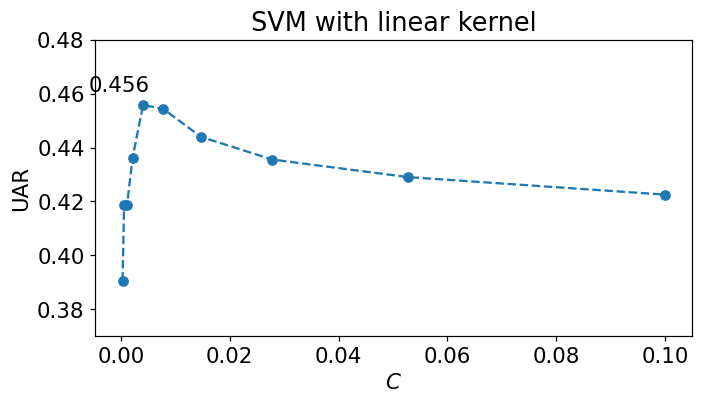

In [13]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

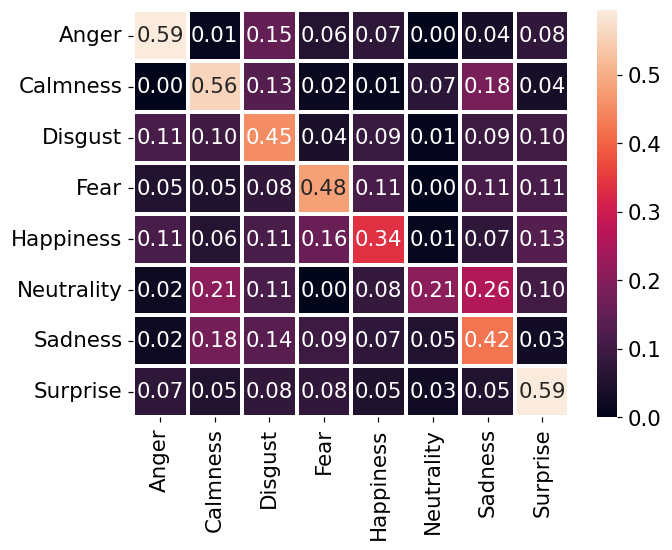

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [14]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [15]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [16]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,-1.676324,-0.746101,0.091157,-0.398224,-0.084387,-0.340691,0.783819,0.507975,0.836294,1.039488,...,-0.134332,3.205445,1.910680,0.460905,-0.838209,-0.171581,0.320386,0.378692,0.027009,0.303059
1,-0.898518,-0.591594,-0.513553,-1.533244,-0.153646,-0.762145,0.297960,-0.578013,-0.651335,-0.930509,...,-0.355068,1.282987,-0.773068,0.010761,-0.404907,-0.948772,-0.921689,-0.966724,-1.266864,-0.718038
2,-0.396159,-0.966012,-0.435643,-0.926990,-0.911184,-0.826127,-0.634355,-0.276989,-0.358897,0.704895,...,0.376201,1.024253,-0.544117,0.448328,-0.139555,-0.362374,-0.435690,-0.800947,-0.658042,-0.533889
3,-2.342224,-1.805384,-0.365858,0.781570,-1.575944,-0.165081,0.094568,0.540148,-0.152562,-0.585777,...,-0.354393,0.677401,-0.158775,0.206376,0.440215,0.805032,1.055052,1.074379,1.484668,0.634002
4,-1.503905,-1.566068,1.209200,0.879542,-0.645613,0.046708,0.070402,1.195381,-0.185243,-0.915401,...,0.125480,-0.266633,-0.725830,2.800967,1.696746,1.528646,2.380480,1.049962,1.113329,0.691989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-0.001314,0.143682,-0.328484,0.857834,1.494971,0.585410,0.699843,1.267308,-0.745707,-0.165505,...,-0.391358,0.908425,-0.895657,0.718057,-0.225792,-0.763993,1.708089,1.622761,0.950851,1.054001
1436,-0.814226,0.604930,0.302839,1.908344,-0.894729,0.095599,1.464856,1.304799,1.556613,-1.339520,...,-0.425734,0.940510,0.764708,2.745473,1.363530,2.042430,1.302288,1.612017,0.208898,0.522795
1437,-0.866613,-0.711070,0.545192,0.489913,1.108665,0.129536,1.172297,1.806541,-1.809360,1.201564,...,0.415159,1.378868,1.396386,2.614695,0.518025,0.975074,1.237795,1.289363,-1.135514,-0.574101
1438,-0.482964,-0.131286,-1.451104,-0.193012,1.432662,-0.580327,0.567737,0.129659,-1.743827,-0.659899,...,-0.730082,-2.289985,-0.668682,0.195309,-0.844747,-1.036383,-0.969465,1.473954,1.047499,0.431326


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.11it/s]

UAR = 0.337


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.68it/s]

UAR = 0.344


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.44it/s]

UAR = 0.355


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.25it/s]

UAR = 0.365


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.54it/s]

UAR = 0.376


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.49it/s]

UAR = 0.382


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.89it/s]

UAR = 0.392


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.92it/s]

UAR = 0.398


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.33it/s]

UAR = 0.400


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.14it/s]

UAR = 0.400


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.20it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.37it/s]

UAR = 0.407


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.97it/s]

UAR = 0.414


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.84it/s]

UAR = 0.422


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.00it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.98it/s]

UAR = 0.418


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.85it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.55it/s]

UAR = 0.421


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.29it/s]

UAR = 0.418


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.33it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.05it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.62it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.10it/s]

UAR = 0.415


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.92it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.78it/s]

UAR = 0.402


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.74it/s]

UAR = 0.396


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.28it/s]

UAR = 0.396


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.81it/s]

UAR = 0.390


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.70it/s]

UAR = 0.385


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.28it/s]

UAR = 0.392


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.67it/s]

UAR = 0.389


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.05it/s]

UAR = 0.383


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.96it/s]

UAR = 0.382


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.73it/s]

UAR = 0.383


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.91it/s]

UAR = 0.383


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.40it/s]

UAR = 0.384


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.16it/s]

UAR = 0.380


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.19it/s]

UAR = 0.381


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.34it/s]

UAR = 0.381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


UAR = 0.378
UAR_best = 0.422, C_best = 0.005


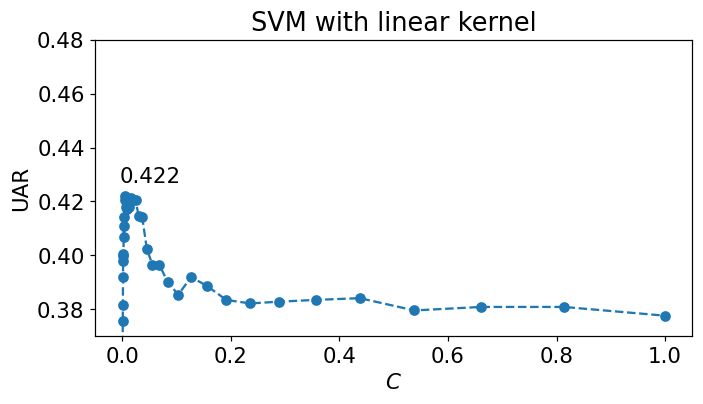

In [17]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

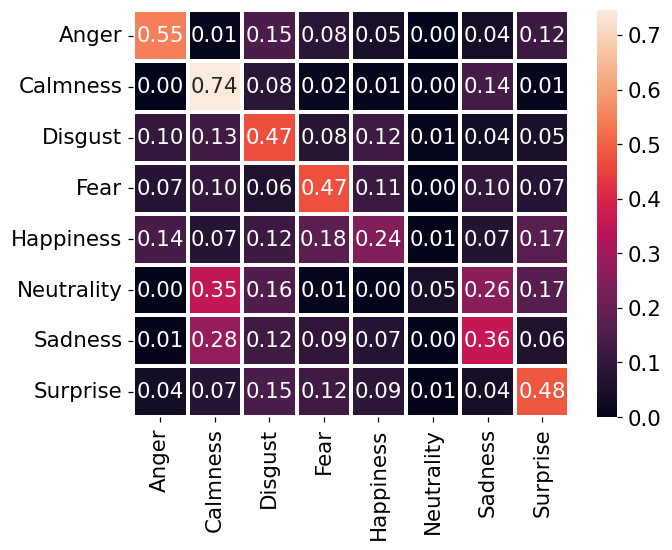

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [18]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)